In [18]:
import pandas as pd
import os
import chromadb
import matplotlib.pyplot as plt
import numpy as np


In [10]:
client = chromadb.PersistentClient("client")

client.heartbeat()

collection = client.get_or_create_collection(name="experimental_psychology")


In [11]:
def AddHighlightedEmbeddings(collection):

    highlighted_list = []
    with open("Sentences/Paragraph/Sample Paragraph - highlighted.txt", "r") as file:
        lines = file.readlines()
        highlighted_list = [line.strip() for line in lines]

    for idx, sentence in enumerate(highlighted_list):
        collection.add(documents=[sentence], ids=[str(idx)], metadatas=[{"highlighted": True}])

def AddNonHighlightedEmbeddings(collection):

    non_highlighted_list = []
    with open("Sentences/Paragraph/Sample Paragraph - non highlighted.txt", "r") as file:
        lines = file.readlines()
        non_highlighted_list = [line.strip() for line in lines]

    for idx, sentence in enumerate(non_highlighted_list):
        collection.add(documents=[sentence], ids=[str(idx + 6)], metadatas=[{"highlighted": False}])

In [ ]:
AddHighlightedEmbeddings(collection)
AddNonHighlightedEmbeddings(collection)

In [13]:
def read_files(directory):
    lines_dict = {"control": [], "experimental": []}

    line_count = 0
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r') as file:
                first_line = file.readline().strip()
                if first_line == 'control':
                    lines = [line.strip() for line in file.readlines()]
                    line_count += len(lines)
                    lines_dict["control"].extend(lines)
                elif first_line == 'experimental':
                    lines = [line.strip() for line in file.readlines()]
                    line_count += len(lines)
                    lines_dict["experimental"].extend(lines )
                else:
                    print(f"Unknown first line in {filepath}: {first_line}")

    print(f"Read {line_count} lines from {directory}")

    return lines_dict

In [14]:
line_map = read_files("Sentences/Participant Recall")

Read 112 lines from Sentences/Participant Recall


In [15]:
print(line_map['experimental'][10])
result = collection.query(query_texts=line_map['experimental'][10], n_results=1)
result["distances"][0][0]

The female pilot - Ria gives a thumbs up to the groundsman and they take off as they see a white flag.


0.5298392211249549

In [16]:
mean_similarities = {
    "control": {
        "highlighted" : [],
        "non-highlighted": []
    },
    "experimental": {
        "highlighted" : [],
        "non-highlighted": [],
    }
}


for sentence in line_map["control"]:
    result = collection.query(query_texts=sentence, n_results=1)
    if result['metadatas'][0][0]["highlighted"]:
        mean_similarities["control"]["highlighted"].append(result["distances"][0][0])
    else: 
        mean_similarities["control"]["non-highlighted"].append(result["distances"][0][0])

for sentence in line_map["experimental"]:
    result = collection.query(query_texts=sentence, n_results=1)
    if result['metadatas'][0][0]["highlighted"]:
        mean_similarities["experimental"]["highlighted"].append(result["distances"][0][0])
    else: 
        mean_similarities["experimental"]["non-highlighted"].append(result["distances"][0][0])


In [17]:
def calculate_mean_std(mean_similarities):
    groups = ['control', 'experimental']
    cases = ['highlighted', 'non-highlighted']

    for group in groups:
        print(f"Group: {group}")
        for case in cases:
            similarities = mean_similarities[group][case]
            mean_similarity = np.mean(similarities)
            std_similarity = np.std(similarities)
            print(f"Case: {case}")
            print(f"Mean Similarity: {mean_similarity}")
            print(f"Count: {len(similarities)}")
            print(f"Standard Deviation of Similarity: {std_similarity}")
            print()

calculate_mean_std(mean_similarities)

Group: control
Case: highlighted
Mean Similarity: 0.44817703560551364
Count: 20
Standard Deviation of Similarity: 0.11959674439445207

Case: non-highlighted
Mean Similarity: 0.44699606080925613
Count: 31
Standard Deviation of Similarity: 0.14371749204039524

Group: experimental
Case: highlighted
Mean Similarity: 0.44719862209441014
Count: 24
Standard Deviation of Similarity: 0.12791150079395

Case: non-highlighted
Mean Similarity: 0.4966505662722591
Count: 37
Standard Deviation of Similarity: 0.12312181166475072



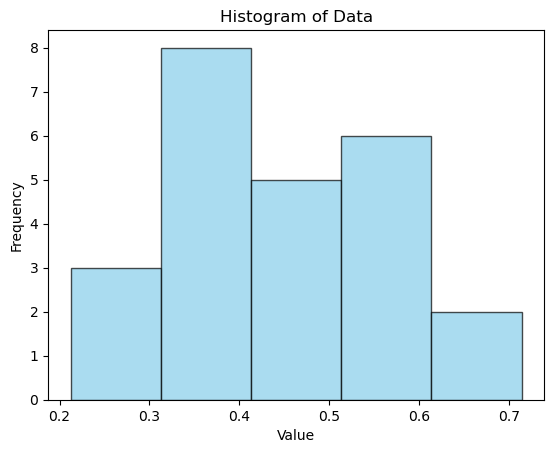

In [ ]:
plt.hist(mean_similarities["experimental"]["highlighted"], bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [19]:
import numpy as np
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(mean_similarities["experimental"]["highlighted"], mean_similarities["control"]["highlighted"], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -0.0255697388736985
P-value: 0.97972348846111


In [20]:
t_stat, p_value = ttest_ind(mean_similarities["experimental"]["non-highlighted"], mean_similarities["control"]["non-highlighted"], equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 1.4906670341157235
P-value: 0.14134029341176138


In [21]:
t_stat, p_value = ttest_ind(mean_similarities["control"]["highlighted"], mean_similarities["control"]["non-highlighted"], equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 0.031107378760721293
P-value: 0.9753198772198404


In [24]:
t_stat, p_value = ttest_ind(mean_similarities["experimental"]["highlighted"], mean_similarities["experimental"]["non-highlighted"], equal_var=False)
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -1.4695170654372598
P-value: 0.14826786326478064


In [32]:
# Define the combinations
combinations = [
    ("control", "highlighted"),
    ("control", "non-highlighted"),
    ("experimental", "highlighted"),
    ("experimental", "non-highlighted")
]

# Initialize an empty list to store the results
results = []

# Calculate t-statistic and p-value for each combination
for i, (group1, case1) in enumerate(combinations):
    for j, (group2, case2) in enumerate(combinations):
        t_stat, p_value = ttest_ind(mean_similarities[group1][case1], mean_similarities[group2][case2], equal_var=False)
        results.append({
            "Group 1": group1,
            "Case 1": case1,
            "Group 2": group2,
            "Case 2": case2,
            "T-statistic": t_stat,
            "P-value": p_value
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)


         Group 1           Case 1       Group 2           Case 2  T-statistic  \
0        control      highlighted       control      highlighted     0.000000   
1        control      highlighted       control  non-highlighted     0.031107   
2        control      highlighted  experimental      highlighted     0.025570   
3        control      highlighted  experimental  non-highlighted    -1.414785   
4        control  non-highlighted       control      highlighted    -0.031107   
5        control  non-highlighted       control  non-highlighted     0.000000   
6        control  non-highlighted  experimental      highlighted    -0.005414   
7        control  non-highlighted  experimental  non-highlighted    -1.490667   
8   experimental      highlighted       control      highlighted    -0.025570   
9   experimental      highlighted       control  non-highlighted     0.005414   
10  experimental      highlighted  experimental      highlighted     0.000000   
11  experimental      highli

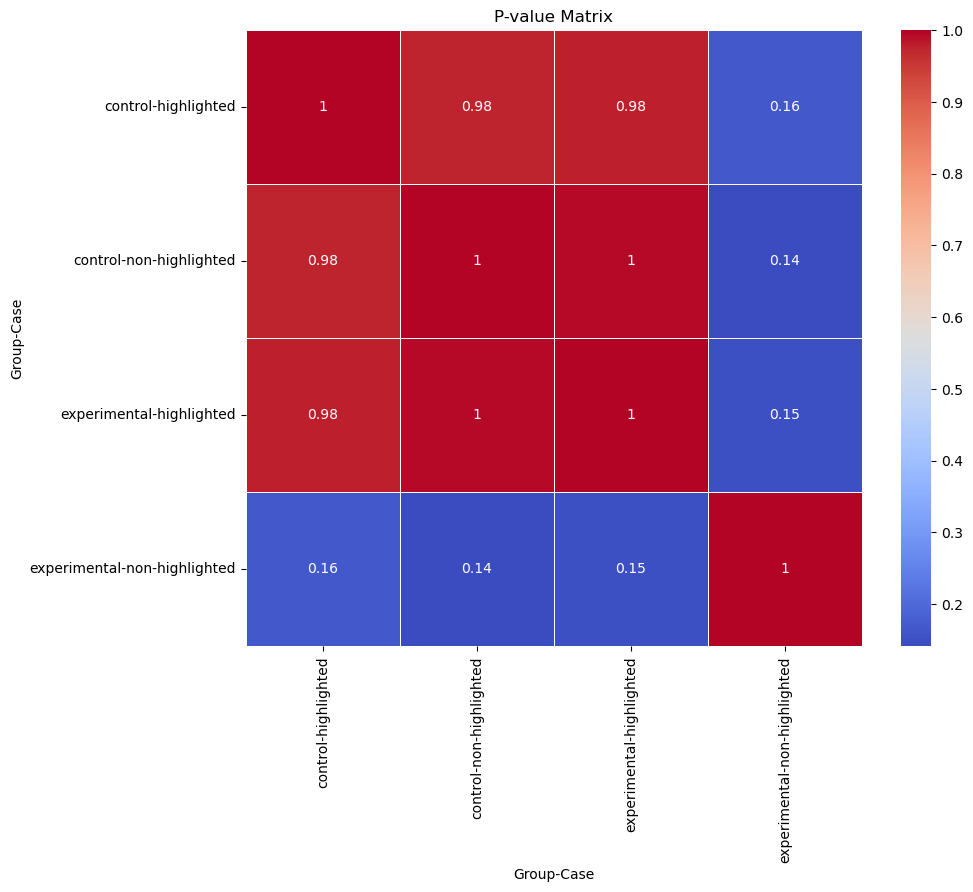

In [28]:
import seaborn as sns
# Create a matrix with the unique combinations as the rows and columns
matrix = pd.DataFrame(index=pd.MultiIndex.from_tuples(combinations, names=["Group", "Case"]),
                      columns=pd.MultiIndex.from_tuples(combinations, names=["Group", "Case"]))

# Fill the matrix with the p-values
for result in results:
    matrix.loc[(result["Group 1"], result["Case 1"]), (result["Group 2"], result["Case 2"])] = result["P-value"]
    matrix.loc[(result["Group 2"], result["Case 2"]), (result["Group 1"], result["Case 1"])] = result["P-value"]

# Convert the matrix to float
matrix = matrix.astype(float)

# Plot the matrix like a correlation matrix
plt.figure(figsize=(10, 8))
plt.title('P-value Matrix')
sns.heatmap(matrix, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.show()

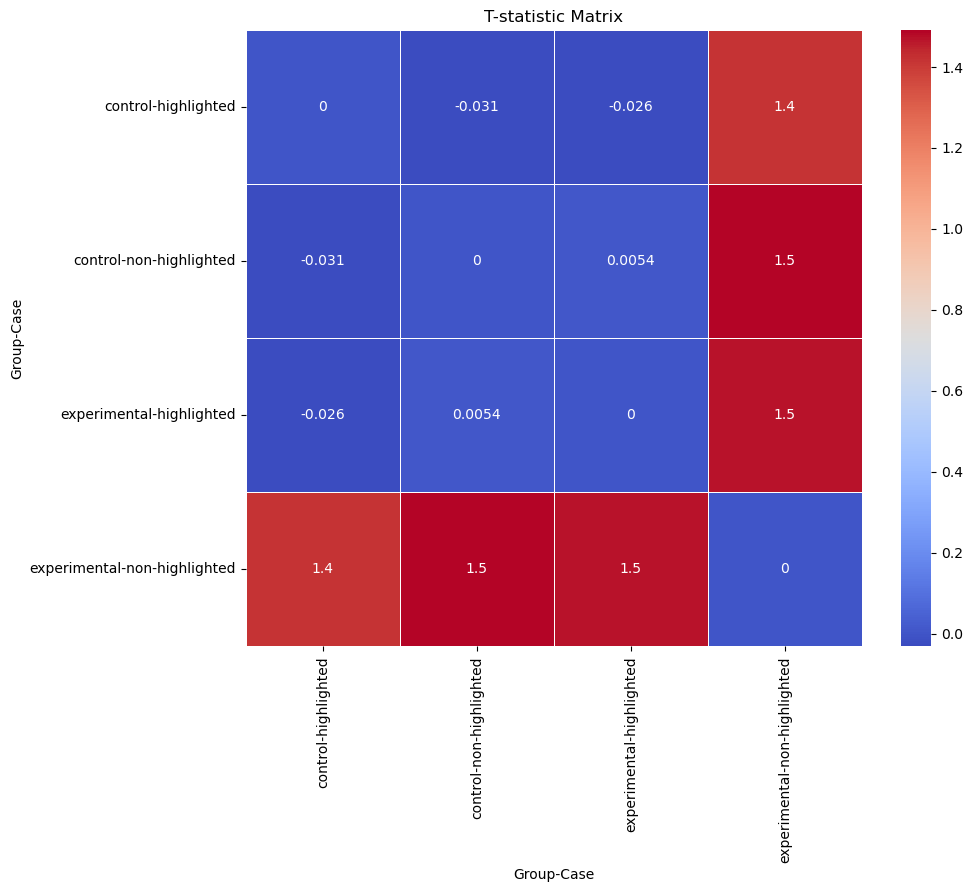

In [33]:
import seaborn as sns
# Create a matrix with the unique combinations as the rows and columns
matrix = pd.DataFrame(index=pd.MultiIndex.from_tuples(combinations, names=["Group", "Case"]),
                      columns=pd.MultiIndex.from_tuples(combinations, names=["Group", "Case"]))

# Fill the matrix with the p-values
for result in results:
    matrix.loc[(result["Group 1"], result["Case 1"]), (result["Group 2"], result["Case 2"])] = result["T-statistic"]
    matrix.loc[(result["Group 2"], result["Case 2"]), (result["Group 1"], result["Case 1"])] = result["T-statistic"]

# Convert the matrix to float
matrix = matrix.astype(float)

# Plot the matrix like a correlation matrix
plt.figure(figsize=(10, 8))
plt.title('T-statistic Matrix')
sns.heatmap(matrix, annot=True, cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.show()